In [2]:
%load_ext autoreload
%autoreload 2

# Preparations

In [3]:
import mkl
mkl.set_num_threads(1)

testing = True # TODO: run in testing mode (fast)

In [4]:
# Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# - this might take several minutes, so run these only if you haven't done so before.

# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
# %run ../../core/resolution.py 
#--renew_calc if you want to repeat the resolution generation (takes a few minutes)

# gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [5]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from fluxes import PL_flux, PLcut_flux, model_flux
from tqdm import tqdm

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [6]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background


In [8]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


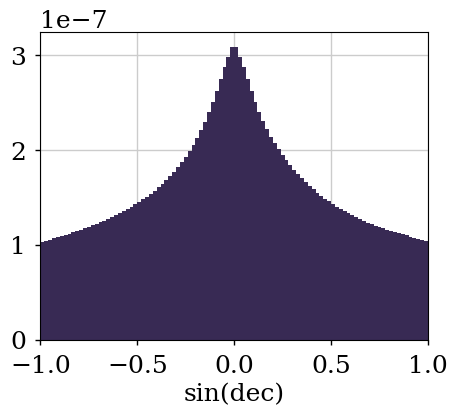

In [9]:
bckg_histo["IceCube"].sum(axis=1, return_mephisto=True).plot()

# Energy resolution function

In [10]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


In [11]:
# save for plotting script
with open(join(st.BASEPATH, "resources/baseline_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((baseline_eres.histo, baseline_eres.bins), f)

with open(join(st.BASEPATH, "resources/improved_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((improved_eres.histo, improved_eres.bins), f)

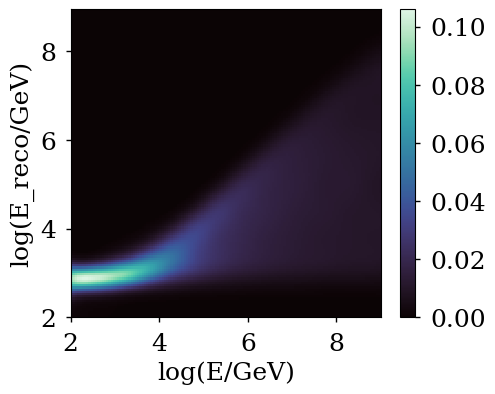

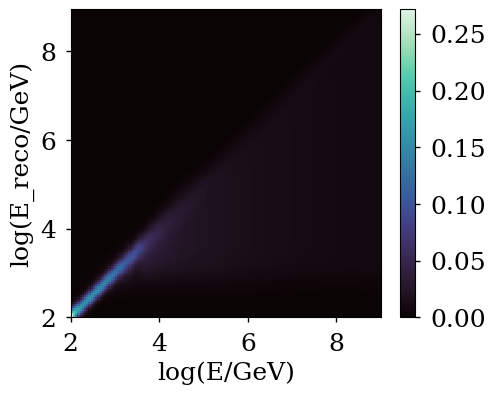

In [12]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

Text(0.5, 1.0, 'Baseline energy resolution')

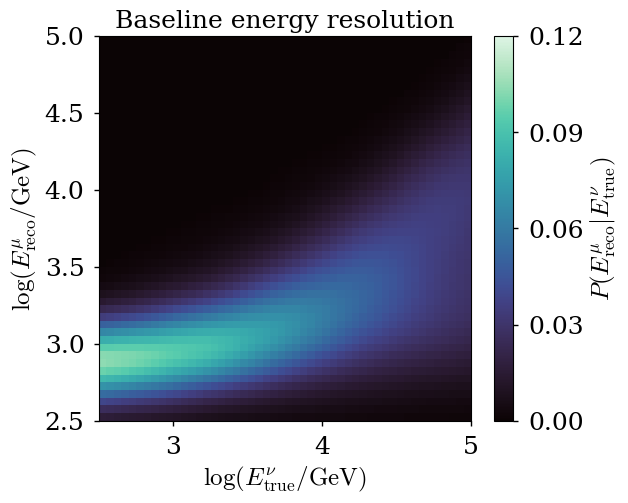

In [13]:
# nice plot
ebounds = (2.5, 5)

f, ax = plt.subplots(figsize=(6, 5))
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=ax, vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")

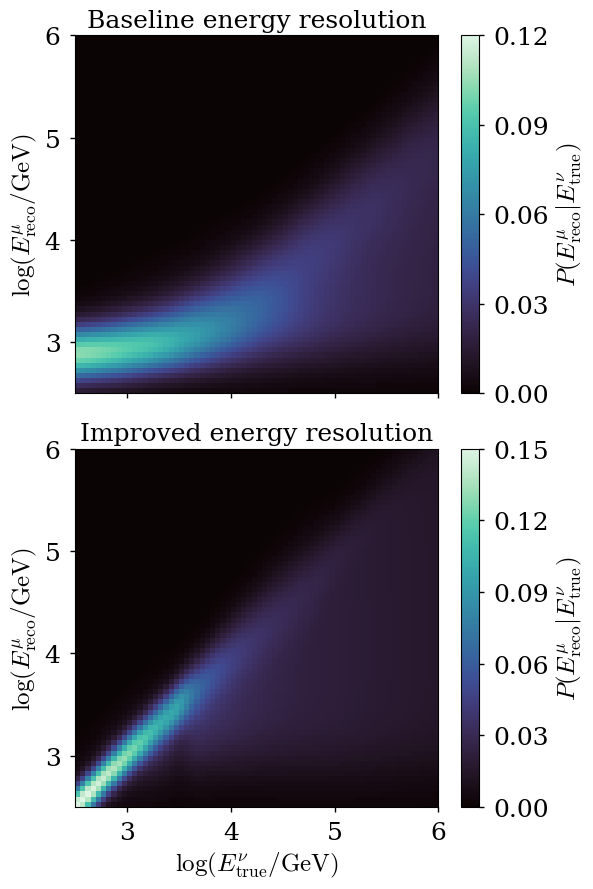

In [14]:
# nice plot
ebounds = (2.5, 6)
ticks = np.arange(3, 7)
f, axes = plt.subplots(nrows=2, figsize=(6, 9), sharex=True)
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=axes[0], vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")
ax.set_yticks(ticks)

f, ax = mephisto.plot_mephistogram(improved_eres, f=f, ax=axes[1], vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True,)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
cb = ax.collections[0].colorbar
cb.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
cb.set_ticks(np.arange(0, 0.16, step=0.03))
ax.set_title("Improved energy resolution")
ax.set_yticks(ticks)

f.tight_layout()
# f.savefig(join(BASEPATH, "plots/ngc_paper/energy_resolution_comparison.pdf"))
# see plotting_standalone.ipynb for final version

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [15]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

Text(0.5, 0, '$\\Psi^2 = |\\Omega_{\\rm true} - \\Omega_{\\rm reco}|^2$')

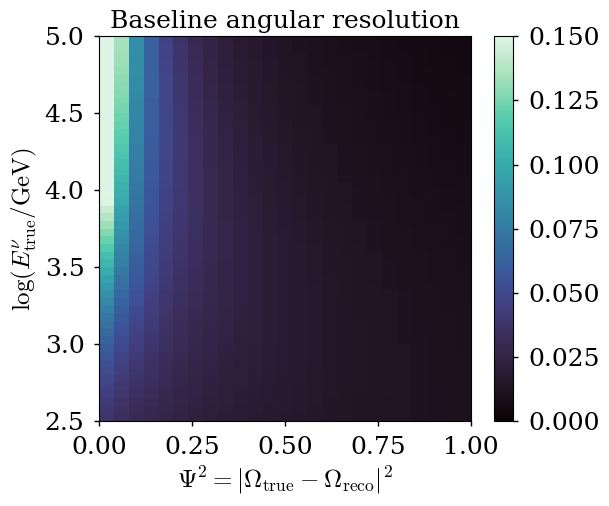

In [16]:

f, ax = plt.subplots(figsize=(6, 5))
ax.set_title("Baseline angular resolution")
f, ax = mephisto.plot_mephistogram(
    e_psi2_grid,
    f=f,
    ax=ax,  vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True, #norm=LogNorm()
)
ax.set_ylim(2.5, 5)
ax.set_xlim(0, 1)
ax.set_ylabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.set_xlabel(r"$\Psi^2 = |\Omega_{\rm true} - \Omega_{\rm reco}|^2$")

# NGC1068 source parameters

In [17]:
from fluxes import ngc_flux, ngc_cut_flux

In [18]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [19]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [20]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~87

ngc 1068: 98.21015338126362


In [21]:
ident = "P-ONE"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~64

ngc 1068: 72.26020264956645


## PL+Cut: source parameters


### scale the fluxes such that the event numbers match

see Plenum/notebooks/misc/energy_spectrum_wiggle.ipynb for in-detail calculation 


In [22]:
## event numbers for IceCube based on NGC 1068 flux
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        ngc_flux,
    )
)
print("IceCube expected number of events:", astro_ev_sum_pl)  # see above
# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        ngc_cut_flux, # already correctly normalized
    )
)
# calculate the flux normalization so that event numbers match für IceCube
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("Need to scale the PL+cutoff flux by:", flux_scaling_cut, "(flux_scaling_cut)")
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# # define the correctly normalized PL+cut flux for NGC 1068
# ngc_cut_flux = PLcut_flux(
#     PHI_NGC * flux_scaling_cut,
#     st.Gamma_cut,
#     st.logE_cut,
#     E0_NGC,
#     "powerlaw with cutoff",
# )

IceCube expected number of events: 98.21015338126362
Need to scale the PL+cutoff flux by: 1.0000000000000002 (flux_scaling_cut)
flux normalization before 5e-14 after 5.0000000000000014e-14


### Plot 1D analysis slice histograms

In [23]:
if False:    
    local_background_flux = array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    np.savetxt(join(BASEPATH, "resources/local_background_ngc.txt"), local_background_flux)
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                ngc_src_config["dec"],
                bckg_histo["IceCube"],
                bckg_histo["IceCube"].bin_mids[0],
                axis=1,
            ),
            energy_resolution=eres,
        )


        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_cut_flux,
        )
        np.savetxt(join(BASEPATH, f"resources/background_events_{e_name}.txt"), k_b)
        np.savetxt(join(BASEPATH, f"resources/PL_events_{e_name}.txt"), k_s_pl)
        np.savetxt(join(BASEPATH, f"resources/PLC_events_{e_name}.txt"), k_s_cut)

# source $\nu_\mu$ : 98.2
# atmo. $\nu_\mu$ : 1461.1 (within 28 deg²)
# source $\nu_\mu$ : 98.2
# atmo. $\nu_\mu$ : 1461.1 (within 28 deg²)


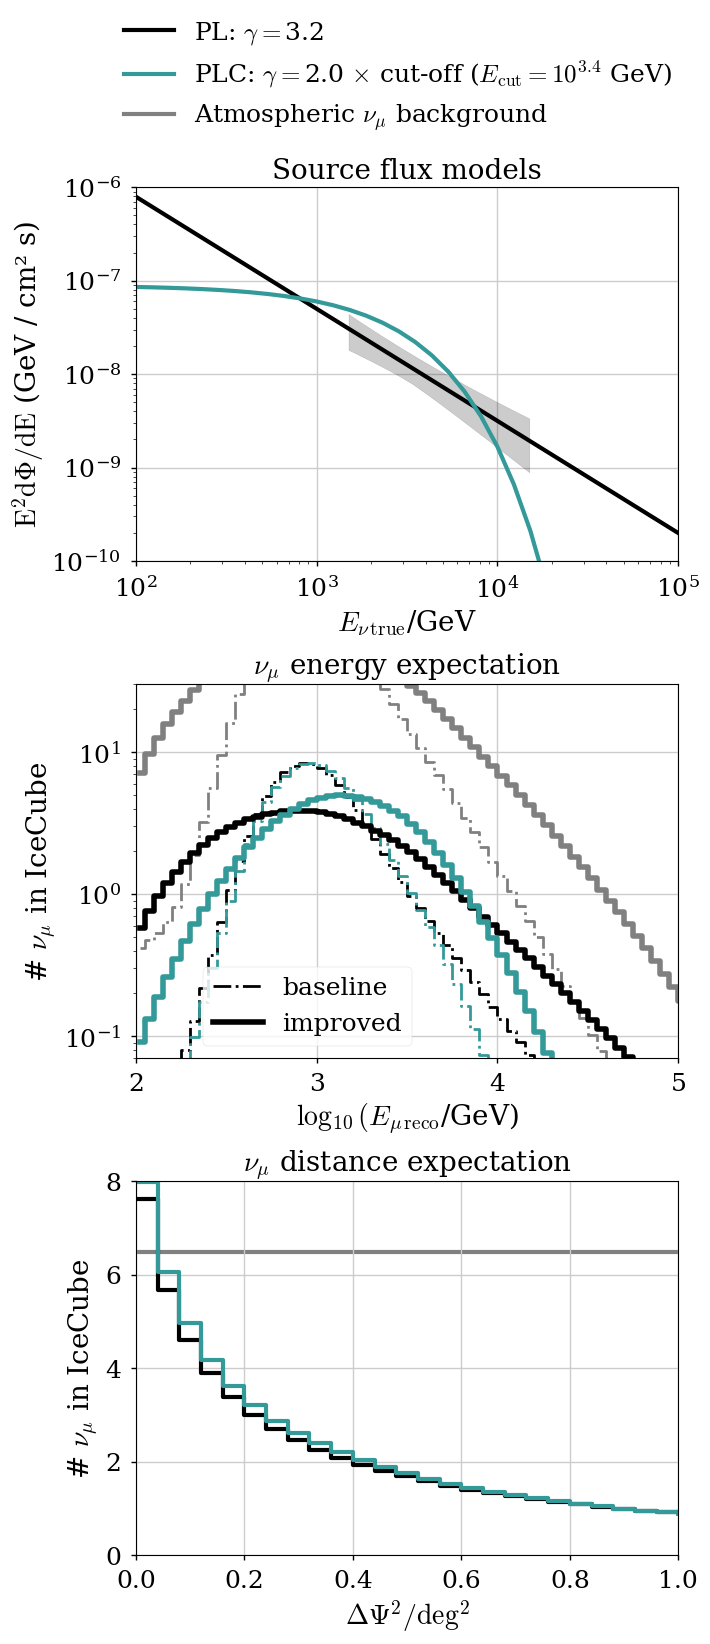

In [24]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL: $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PLC: $\gamma=${st.Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** aeff_factor_signal.bin_mids[1],
    array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    * sq_deg
    * (10 ** aeff_factor_signal.bin_mids[1] ** y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = baseline_eres.bin_mids[1]
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(
            ngc_src_config["dec"],
            bckg_histo["IceCube"],
            bckg_histo["IceCube"].bin_mids[0],
            axis=1,
        ),
        energy_resolution=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_flux,
    )

    # cutoff
    k_s_cut = astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_cut_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=e_name,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

# f.savefig(
#     join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
#     bbox_inches="tight",
# )
# see plotting_standalone.ipynb for final version

In [25]:
if False:
    sq_deg = np.pi * st.delta_psi_max**2
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 2

    pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
    cut = power_law(
        x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

    f, axes = plt.subplots(ncols=2, figsize=(14, 6))
    ax = axes[0]
    fontsize = 20
    ax.set_title("Source flux models", fontsize=fontsize)

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
    # without energy range interval
    # x_cont = np.logspace(1.9, 5.1, 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    for ii, xe in enumerate(x_cont):
        tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)
    ax.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.2,
    )

    ax.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"PL: $\gamma=${GAMMA_NGC}",
        color="k",
        alpha=1,
        lw=4,
    )

    ax.plot(
        x_evals,
        cut * (x_evals**y_scaling),
        label=rf"PLC: $\gamma=${st.Gamma_cut} $\times$ "
        + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
        color="#339999",
        lw=4,
    )
    ax.plot(
        10 ** aeff_factor_signal.bin_mids[1],
        array_source_interp(
            ngc_src_config["dec"],
            bckg_histo["IceCube"],
            bckg_histo["IceCube"].bin_mids[0],
            axis=1,
        )
        * sq_deg
        * (10 ** aeff_factor_signal.bin_mids[1] ** y_scaling),
        label=r"Atmospheric $\nu_\mu$ background",
        color="gray",
        lw=4,
    )

    ax.set_yscale("log")
    ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
    ax.set_xscale("log")
    ax.set_xlabel(r"$E_{\nu, \rm true}$/GeV", fontsize=fontsize)
    ax.set_ylim(1e-10, 1e-6)
    ax.set_xlim(1e2, 1e5)
    f.legend(
        loc="upper center",
        frameon=False,
        ncols=3,
        bbox_to_anchor=(0.5, 0.93),
    )


    ### plot Event numbers in E_reco
    ii = 0
    evals = baseline_eres.bin_mids[1]
    ax = axes[1]
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    for eres, e_name in zip([improved_eres], ["improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                ngc_src_config["dec"],
                bckg_histo["IceCube"],
                bckg_histo["IceCube"].bin_mids[0],
                axis=1,
            ),
            energy_resolution=eres,
        )

        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_cut_flux,
        )

        ax = axes[1]
        ax.plot(
            evals,
            k_s_pl.sum(axis=0),
            drawstyle="steps-mid",
            # label=e_name,
            color="k",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_s_cut.sum(axis=0),
            drawstyle="steps-mid",
            color="#339999",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_b.sum(axis=0),
            drawstyle="steps-mid",
            color="gray",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )
        print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
        print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
    ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
    ax.set_yscale("log")
    ax.set_xlim(2, 5)
    ax.set_ylim(7e-2, 3e1)
    ax.set_xlabel(r"$\log_{10}(E_{\mu, \rm reco}$/GeV)", fontsize=fontsize)
    ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
    ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
    ax.set_xticks([2, 3, 4, 5])

    f.subplots_adjust(wspace=0.33, top=0.75)

    # f.savefig(
    #     join(BASEPATH, f"plots/ngc_paper/ngc_spectral_horizontal.pdf"),
    #     bbox_inches="tight",
    # )
    # see plotting_standalone.ipynb for final version

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# NGC 1068
## Significance test Background vs. Background + Signal

In [26]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for eres, key in product([baseline_eres, improved_eres], detector_keys):
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres=eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06720916]
Signal fit parameters: [1.  1.  3.2]
TS check: -303610.6245645325 (fit:  -303610.6245645325 )
-2 Delta LLH: 22.149885757709853
P-VALUE: 1.5495779230132744e-05 SIGNIFICANCE: 4.166055278008453

Plenum-1
Atmo-only normalization: [1.09227092]
Signal fit parameters: [1.  1.  3.2]
TS check: -1358596.0676056454 (fit:  -1358596.0676056454 )
-2 Delta LLH: 125.89580024033785
P-VALUE: 4.5927661226817185e-28 SIGNIFICANCE: 10.92063109019143

Plenum-2
Atmo-only normalization: [1.07525586]
Signal fit parameters: [1.  1.  3.2]
TS check: -1316599.2441259185 (fit:  -1316599.2441259185 )
-2 Delta LLH: 271.6447326024063
P-VALUE: 1.0306134272941642e-59 SIGNIFICANCE: 16.254924320982198

IceCube
Atmo-only normalization: [1.06721091]
Signal fit parameters: [1.  1.  3.2]
TS check: -278264.5839474215 (fit:  -278264.5839474215 )
-2 Delta LLH: 23.2261633030721
P-VALUE: 9.046961056228475e-06 SIGNIFICANCE: 4.287200188086375

Plenum-1
Atmo-only normalization: [1.09227257

# 1D contours

In [26]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.025
gamma_astro = np.arange(2.85, 3.6, step=step)
astro_scaling = np.arange(0.6, 1.45, step=step)
if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_flux
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["Energy res."] = eres_key
        tmp["Detector"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["Flux normalization relative to baseline flux"] = out[0][1]
        tmp["Spectral index"] = out[0][2]
        tmp["fixed"] = "None"
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, aa in enumerate(astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, x[1]), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1, 2], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["Energy res."] = eres_key
            tmp["Detector"] = ident
            tmp["fixed"] = "Flux normalization relative to baseline flux"
            tmp["ts"] = local_out[1]
            tmp["$-2\Delta$ LLH"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["Flux normalization relative to baseline flux"] = aa
            tmp["Spectral index"] = local_out[0][1]
            tmp_SPL.append(tmp)

        for jj, gg in enumerate(gamma_astro):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], x[1], gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1, 1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["Energy res."] = eres_key
            tmp["Detector"] = ident
            tmp["fixed"] = "Spectral index"
            tmp["ts"] = local_out[1]
            tmp["$-2\Delta$ LLH"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["Spectral index"] = gg
            tmp["Flux normalization relative to baseline flux"] = local_out[0][1]
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_1D_contours_spl.pickle"))
else:
    SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_1D_contours_spl.pickle"))

IceCube (['IceCube'], [1]) baseline
IceCube (['IceCube'], [1]) improved
P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved
info: IceCube (['IceCube'], [1]) baseline
starting local fits...


info: IceCube (['IceCube'], [1]) improved
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved
starting local fits...
done


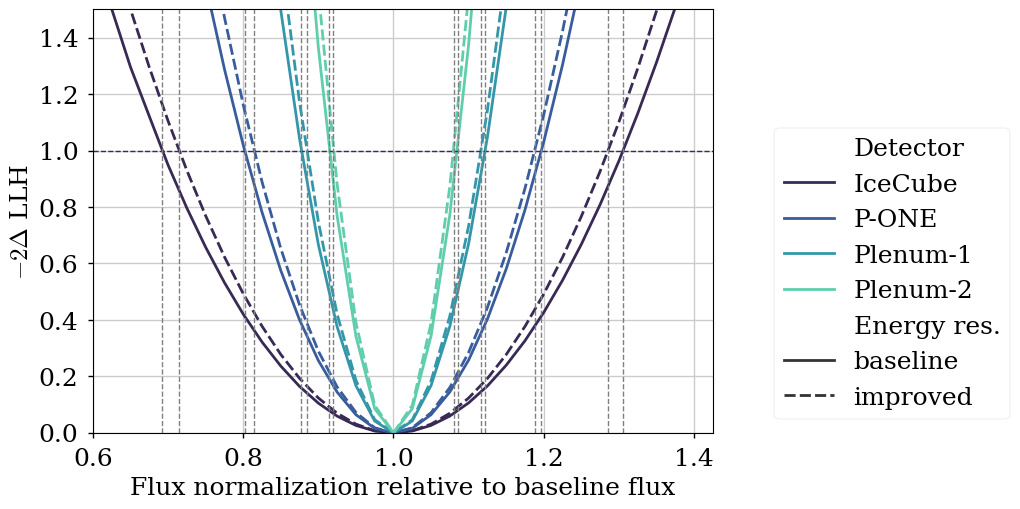

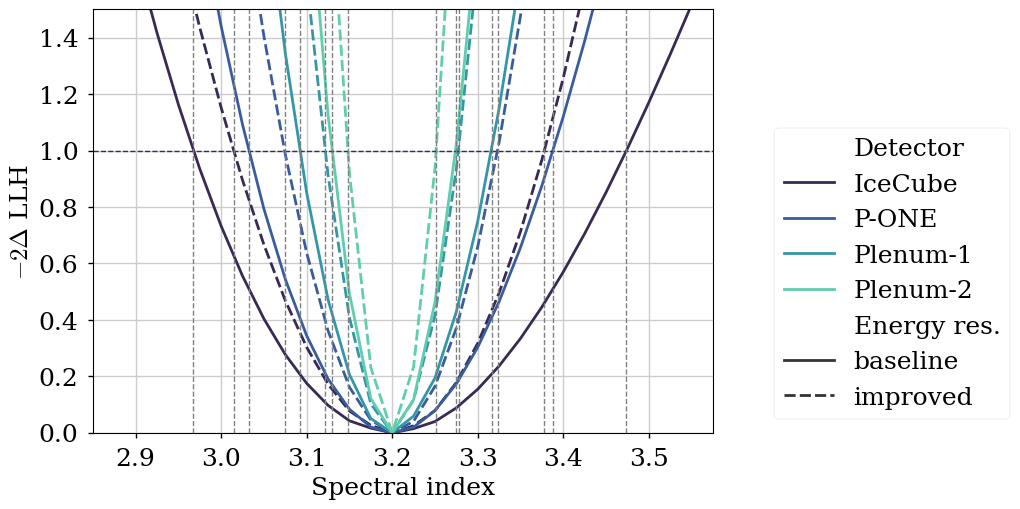

In [27]:
plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Flux normalization relative to baseline flux"]
sns.lineplot(
    data=selection,
    x="Flux normalization relative to baseline flux",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 1.5)
plt.xlim(astro_scaling[0], astro_scaling[-1])
plt.legend(
    bbox_to_anchor=(1.5, 0.75),
    loc=1,
)
plt.axhline(1, ls="--", lw=1)
norm_bounds = []
for (eres, det), series in selection.groupby(["Energy res.", "Detector"]):
    # spline
    # 1sigma bound on norm
    mask = series["Flux normalization relative to baseline flux"] < 1
    _spline = InterpolatedUnivariateSpline(
        series["Flux normalization relative to baseline flux"],
        series["$-2\Delta$ LLH"] - 1,
    )
    norm_plusminus = _spline.roots()
    plt.axvline(norm_plusminus[0], ls="--", lw=1, color="gray")
    plt.axvline(norm_plusminus[1], ls="--", lw=1, color="gray")
    norm_bounds.append(
        {
            "Energy res.": eres,
            "Detector": det,
            "norm_minus": norm_plusminus[0],
            "Delta_norm_minus": 1 - norm_plusminus[0],
            "Delta_norm_plus": norm_plusminus[1] - 1,
            "norm_plus": norm_plusminus[1],
            "norm_avg": 0.5 * (norm_plusminus[1] - norm_plusminus[0]),
            r"$ N= 1 \pm \sigma$": rf"${{}}^{{+{norm_plusminus[1] - 1:1.2f}}}_{{{norm_plusminus[0] - 1:1.2f}}}$",
            r"$ N= 1 \pm 1\sigma$": rf"$\pm {0.5 * (norm_plusminus[1] - norm_plusminus[0]):1.2f}$",
        }
    )
norm_bounds = pd.DataFrame(norm_bounds)


plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Spectral index"]
sns.lineplot(
    data=selection,
    x="Spectral index",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 1.5)
plt.xlim(gamma_astro[0], gamma_astro[-1])
plt.legend(
    bbox_to_anchor=(1.5, 0.75),
    loc=1,
)
plt.axhline(1, ls="--", lw=1)

gamma_bounds = []
for (eres, det), series in selection.groupby(["Energy res.", "Detector"]):
    # spline
    # 1sigma bound on gamma
    _spline = InterpolatedUnivariateSpline(
        series["Spectral index"],
        series["$-2\Delta$ LLH"]-1,
    )
    gamma_plusminus = _spline.roots()  # 1 sigma lower bound
    plt.axvline(gamma_plusminus[0], ls="--", lw=1, color="gray")
    plt.axvline(gamma_plusminus[1], ls="--", lw=1, color="gray")
    gamma_bounds.append(
        {
            "Energy res.": eres,
            "Detector": det,
            "gamma_minus": gamma_plusminus[0],
            "Delta_gamma_minus": st.GAMMA_NGC - gamma_plusminus[0],
            "Delta_gamma_plus": gamma_plusminus[1] - st.GAMMA_NGC,
            "gamma_plus": gamma_plusminus[1],
            "gamma_avg": 0.5 * (gamma_plusminus[1] - gamma_plusminus[0]),
            rf"$\gamma = {st.GAMMA_NGC} \pm \sigma$": rf"${{}}^{{+{gamma_plusminus[1] - st.GAMMA_NGC:1.2f}}}_{{{gamma_plusminus[0] - st.GAMMA_NGC:1.2f}}}$",
            rf"$\gamma = {st.GAMMA_NGC} \pm 1\sigma$": rf"$\pm {0.5 * (gamma_plusminus[1] - gamma_plusminus[0]):1.2f}$",
        }
    )
gamma_bounds = pd.DataFrame(gamma_bounds)

In [28]:
parameter_bounds = (
    pd.merge(norm_bounds, gamma_bounds)[
        [
            "Energy res.",
            "Detector",
            "$ N= 1 \pm 1\sigma$",
            "$\gamma = 3.2 \pm 1\sigma$",
        ]
    ]
    .set_index(["Detector", "Energy res."])
    .sort_index()
)
parameter_bounds

$ N= 1 \pm 1\sigma$ $\gamma = 3.2 \pm 1\sigma$
Detector Energy res.                                               
IceCube  baseline             $\pm 0.31$                 $\pm 0.25$
         improved             $\pm 0.29$                 $\pm 0.18$
P-ONE    baseline             $\pm 0.20$                 $\pm 0.18$
         improved             $\pm 0.19$                 $\pm 0.12$
Plenum-1 baseline             $\pm 0.12$                 $\pm 0.11$
         improved             $\pm 0.12$                 $\pm 0.08$
Plenum-2 baseline             $\pm 0.09$                 $\pm 0.07$
         improved             $\pm 0.08$                 $\pm 0.05$

In [29]:
print(parameter_bounds.to_latex(float_format="%.2f", sparsify=True))

\begin{tabular}{llll}
\toprule
 &  & $ N= 1 \pm 1\sigma$ & $\gamma = 3.2 \pm 1\sigma$ \\
Detector & Energy res. &  &  \\
\midrule
\multirow[t]{2}{*}{IceCube} & baseline & $\pm 0.31$ & $\pm 0.25$ \\
 & improved & $\pm 0.29$ & $\pm 0.18$ \\
\cline{1-4}
\multirow[t]{2}{*}{P-ONE} & baseline & $\pm 0.20$ & $\pm 0.18$ \\
 & improved & $\pm 0.19$ & $\pm 0.12$ \\
\cline{1-4}
\multirow[t]{2}{*}{Plenum-1} & baseline & $\pm 0.12$ & $\pm 0.11$ \\
 & improved & $\pm 0.12$ & $\pm 0.08$ \\
\cline{1-4}
\multirow[t]{2}{*}{Plenum-2} & baseline & $\pm 0.09$ & $\pm 0.07$ \\
 & improved & $\pm 0.08$ & $\pm 0.05$ \\
\cline{1-4}
\bottomrule
\end{tabular}



(2.85, 3.5749999999999975)

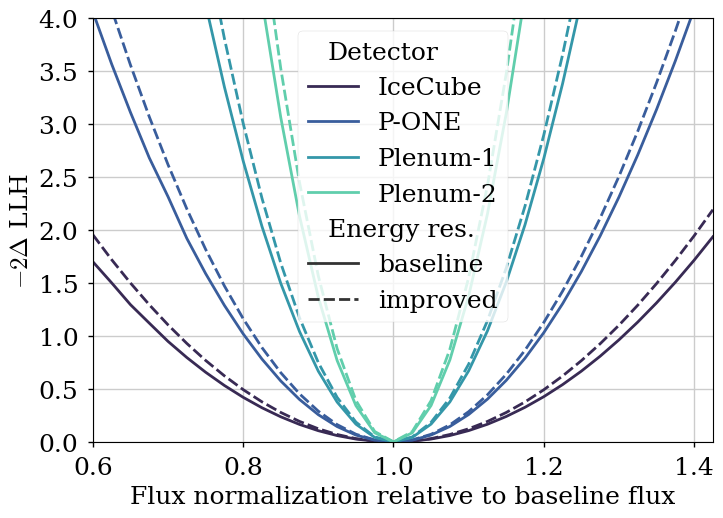

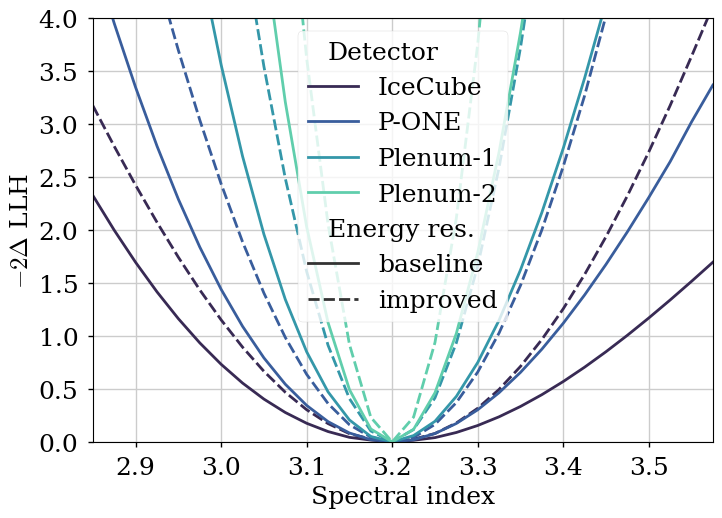

In [30]:
# plotting only
plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Flux normalization relative to baseline flux"]
sns.lineplot(
    data=selection,
    x="Flux normalization relative to baseline flux",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 4)
plt.xlim(astro_scaling[0], astro_scaling[-1])

plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Spectral index"]
sns.lineplot(
    data=selection,
    x="Spectral index",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 4)
plt.xlim(gamma_astro[0], gamma_astro[-1])

# 2D contour
## Grid scan

In [31]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "P-ONE": {"colors": [st.poles["P-ONE"]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
}
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

IceCube (['IceCube'], [1]) baseline
IceCube (['IceCube'], [1]) improved
P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved


In [32]:
energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.05
gamma_astro = np.arange(2.7, 4, step=step)
astro_scaling = np.arange(0.4, 1.6, step=step)
if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_flux
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["energy_res"] = eres_key
        tmp["ident"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["phi_astro"] = out[0][1]
        tmp["gamma"] = out[0][2]
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, (aa, gg) in enumerate(product(astro_scaling, gamma_astro)):
            # if jj%int(len(astro_scaling) * len(gamma_astro)/5) == 0: print("it", jj)
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["energy_res"] = eres_key
            tmp["ident"] = ident

            tmp["ts"] = local_out[1]
            tmp["delta_ts"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["phi_astro"] = aa
            tmp["gamma"] = gg
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))

info: IceCube (['IceCube'], [1]) baseline
starting local fits...


info: IceCube (['IceCube'], [1]) improved
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved
starting local fits...
done


In [33]:
import matplotlib

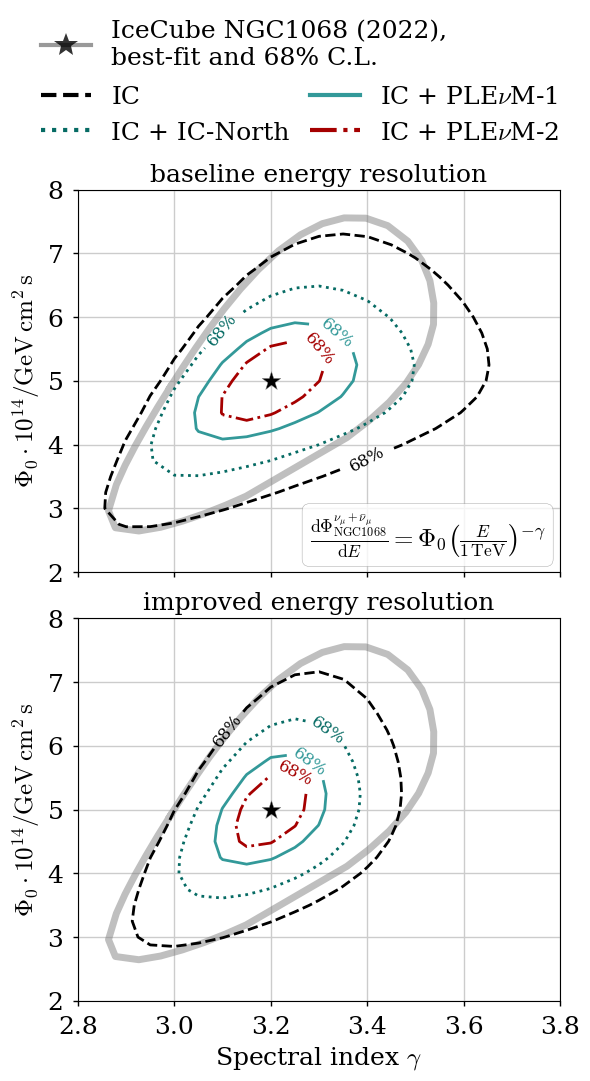

In [34]:
SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
        fmt = {l: s for l, s in zip(sc.levels, lbs)}
        ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="k",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.8, 3.8)
    ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
    ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index $\gamma$")

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label="IceCube NGC1068 (2022),\nbest-fit and 68% C.L.",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["P-ONE"]["colors"][0],
        ls=contour_formats["P-ONE"]["linestyles"],
        lw=3,
        label="IC + IC-North",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-2",
    ),
]
leg1 = f.legend(
    handles=[
        lines[0],
    ],
    loc="upper left",
    ncol=1,
    bbox_to_anchor=(0.04, 0.99),
    # fontsize="x-large",
    frameon=False,
)
f.legend(
    handles=lines[1:],
    loc="upper left",
    ncol=2,
    bbox_to_anchor=(0.04, 0.93),
    columnspacing=0.8,
    # fontsize="x-large",
    frameon=False,
)
# ax.add_artist(leg1)

flux_str = r"$\frac{{\rm d}\Phi_{\rm NGC 1068}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
for ax in axes:
    ax.text(
        0.97,
        0.07,
        flux_str,
        fontsize=18,
        transform=ax.transAxes,
        ha="right",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
    )
    break
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
f.subplots_adjust(top=0.815)

# f.savefig(join(BASEPATH, "plots/ngc_paper/2D_scan_ngc1068.pdf"))
# see plotting_standalone.ipynb for final version

### Translate contour to flux plot

In [35]:
## something isn't working anymore here ?! ... not that important, though

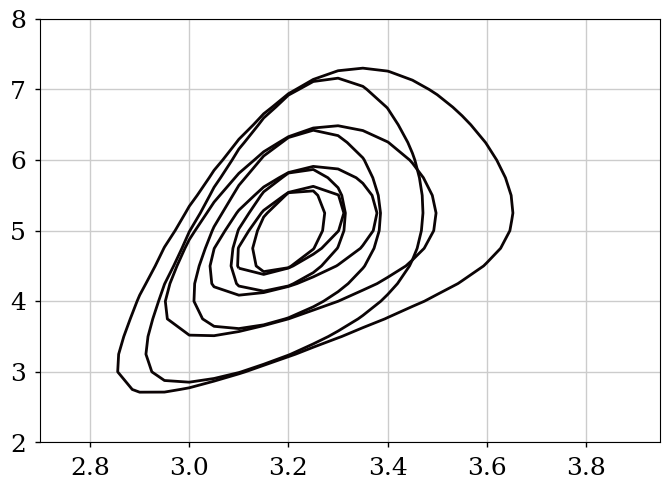

In [36]:
plenum_ngc_contours = []
for eres_key in energy_reso:
    # draw contour levels
    cvals = [0.32]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = plt.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
        )

        plenum_ngc_contours.append(
            {
                "energy_resolution": eres_key,
                "ident": ident,
                "level": levels[0],
                "contour": sc.allsegs[0][0],
            }
        )
plenum_ngc_contours = pd.DataFrame(plenum_ngc_contours)

In [37]:
if False:
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 3.2
    f, axx = plt.subplots()

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    # paper reference contour
    for ii, xe in enumerate(x_cont):
        tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)


    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor="k",
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
        label="Paper Contour",
    )

    # our contour
    for eres_key in energy_reso:
        plenum_contour = plenum_ngc_contours.loc[
            (plenum_ngc_contours.energy_resolution == eres_key)
            & (plenum_ngc_contours.ident == "IceCube")
        ].contour.iloc[0]

        plenum_low = np.zeros_like(x_cont)
        plenum_high = np.zeros_like(x_cont)

        for ii, xe in enumerate(x_cont):
            tmp = power_law(
                xe, ngc_flux.E0, plenum_contour[:, 0], plenum_contour[:, 1] * 1e-14
            )
            plenum_low[ii] = np.min(tmp)
            plenum_high[ii] = np.max(tmp)
        axx.fill_between(
            x_cont,
            plenum_low * (x_cont**y_scaling),
            plenum_high * (x_cont**y_scaling),
            edgecolor="tab:blue" if eres_key == "baseline" else "crimson",
            facecolor=(0, 0, 0, 0),
            lw=3,
            zorder=15,
            ls="-" if eres_key == "baseline" else ":",
            label="PLEnuM Contour, " + eres_key,
        )

    # power law flux
    pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color="k",
        alpha=1,
        zorder=10,
        lw=3,
    )

    # settings
    axx.set_title("NGC 1068 flux")
    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
    axx.set_xlim(3e2, 1e5)
    axx.legend(loc=0, frameon=False)
    # very nice

# Disc. potential vs dec

In [38]:
# standard
thresholds = [sigma5]
detector_keys = [
    "IceCube" ,
    "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.arange(-90, 91, step=5)

tmp = []  # save output here
for ident in detector_keys:
    conf = st.detector_configurations[ident]
    
    for dec in tqdm(np.deg2rad(decs)):
        if "IceCube" in ident and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_flux
        )
        # calculate an estimate for the flux scaling
        scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "pval": pval,
                "log10(p)": -np.log10(pval),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))

 49%|████▊     | 18/37 [00:00<00:00, 45.21it/s]

100%|██████████| 37/37 [00:42<00:00,  1.16s/it]


In [39]:
df = pd.read_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()
flux["dec_deg"] = np.rad2deg(flux.dec)

In [40]:
flux.to_pickle(join(BASEPATH, "resources/flux_ngc_disc_pot.pickle"))

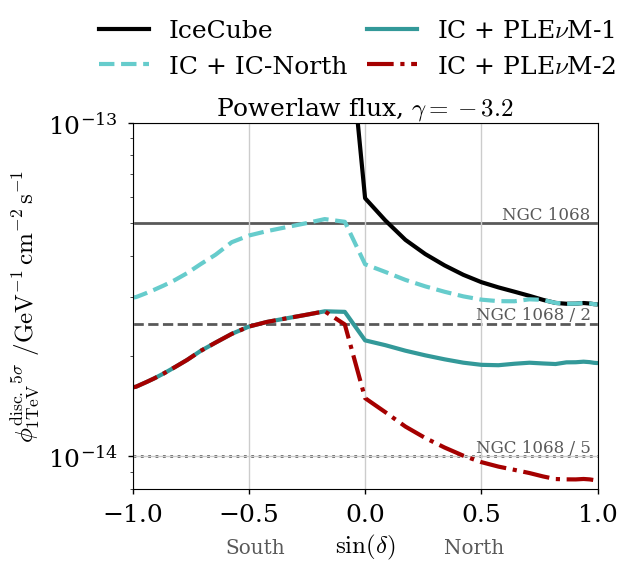

In [41]:
f, ax = plt.subplots(figsize=(6, 6))
for ident, series in flux.groupby("ident"):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.set_yscale("log")
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
ax.set_ylim(8e-15, 1e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_flux.norm / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large", ha="right"
    )
ax.text(0.2, -0.175, "South", fontsize="x-large", color=font_color, transform=ax.transAxes)
ax.text(0.8, -0.175, "North", ha="right", fontsize="x-large", color=font_color, transform=ax.transAxes)

f.subplots_adjust(top=0.72)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")

# f.savefig(join(BASEPATH, "plots/ngc_paper/ngc_disc_pot.pdf"), bbox_inches="tight")
# f.savefig(join(BASEPATH, "plots/ngc_paper/ngc_disc_pot.png"), bbox_inches="tight", dpi=200)
# see plotting_standalone.ipynb for final version

# Power law vs. Power-law with cutoff


In [42]:
identifier = "IceCube"
conf = (['IceCube'], [1]) # 10 yr

(
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_k,
    all_bckg_flux,
    all_eres,
) = setup_multi_llh(
    improved_eres,  # select one resolution for all data sets
    conf,
    aeff_2d=aeff_2d,
    bckg_histo=bckg_histo,
    bg_config=ngc_bg_config,
    sig_config=ngc_src_config,
    src_flux=ngc_cut_flux,
)

dct = dict(
    all_aeff_factor_s=all_aeff_factor_s,
    all_aeff_factor_b=all_aeff_factor_b,
    all_k=all_k,
    all_bckg_flux=all_bckg_flux,
    all_eres=all_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
)
pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
out_bckg = fmin_l_bfgs_b(
    pl_func,
    x0=(1.2, 1.2, 3.0),
    bounds=[(1E-3, 100), (1E-3, 100), (0.1, 5)],
    approx_grad=True,
)
print("powerlaw params:", out_bckg[0])

comp = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
out_comp = fmin_l_bfgs_b(
    comp,
    x0=(1.2, 1.1, 1.9, 3.4),
    bounds=[(1E-3, 100), (1E-3, 100), (0.1, 5), (1, 10)],
    approx_grad=True,
)
print("global params:", out_comp[0])
print("true params:", (1, 1, st.Gamma_cut, st.logE_cut))

# check the LLH at the "correct" parameter position
check = comp((1, 1, st.Gamma_cut, st.logE_cut))
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
pval_check = chi2.sf(out_bckg[1] - check, 1)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("pval check:", pval_check, "ratio:", pval_check / pval)
print("")

powerlaw params: [0.99856237 1.0033897  3.13195456]
global params: [0.99974487 1.69599144 2.11063381 3.45436247]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.03428954896059059 SIGNIFICANCE: 1.8211826435229532
pval check: 1.0 ratio: 29.163404894864982



## normal vs. improved E resolution

In [43]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
detector_conf = [{"key": k, "identifier": det_plotting[k]["label"]} for k in idents]

eres_conf = (
    {"e_file": e_res_files["baseline"], "e_name": "Baseline"},
    {"e_file": e_res_files["1:1"], "e_name": "Removed bias"},
    #{"e_file": e_res_files["improved-20"], "e_name": "20% improv."},
    {"e_file": e_res_files["improved-50"], "e_name": "50% improv."},
)
# livetime relative to 10yrs

eres_detector_configurations = []
for dc, eresc in product(detector_conf, eres_conf):
    eres_detector_configurations.append(dc | eresc)
eres_detector_configurations = pd.DataFrame(eres_detector_configurations)

eres_detector_configurations

,key,identifier,e_file,e_name
0,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
1,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
2,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
3,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
4,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
5,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
6,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
7,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
8,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
9,Plenum-2,IC + PLE$\nu$M-2,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline


### Significance

In [44]:
pvals_ngc = []
for (identifier, es_ident), series in eres_detector_configurations.groupby(
    ["identifier", "e_name"], sort=False
):
    conf = st.detector_configurations[series.key.iloc[0]]
    print("info:", identifier, conf, es_ident)
    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        eres = pickle.load(f)
    eres.normalize(axis=1)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=ngc_cut_flux, # baseline truth
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
    )
    pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", phi_0=ngc_flux.norm, **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        bounds=[(1e-3, 100), (1e-3, 100), (0.1, 5)],
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_multi(
        x, shape="powerlaw with cutoff", phi_0=ngc_cut_flux.norm, **dct
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        bounds=[(1e-3, 100), (1e-3, 100), (0.1, 5), (1, 10)],
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, st.Gamma_cut, st.logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, st.Gamma_cut, st.logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))

info: IceCube (['IceCube'], [1]) Baseline
/home/hpc/capn/capn102h/repos/Plenum/local/energy_smearing_GP_up.pckl
bckg params: [0.99302748 1.11745207 3.32051504]
global params: [0.99884566 1.08043183 2.01101329 3.37495587]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.37160689095372323 SIGNIFICANCE: 0.3276004496572293
pval check: 0.36835371836451825 ratio: 0.991245661293159

info: IceCube (['IceCube'], [1]) Removed bias
/home/hpc/capn/capn102h/repos/Plenum/local/idealized_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99833569 1.00911191 3.14066743]
global params: [0.99864888 1.07346047 1.99452642 3.37676483]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.03785845176796362 SIGNIFICANCE: 1.776097164421916
pval check: 0.03743918725520168 ratio: 0.9889254712440003

info: IceCube (['IceCube'], [1]) 50% improv.
/home/hpc/capn/capn102h/repos/Plenum/local/improved_0.5_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99856237 1.0033897  3.13195456]
global params: [0.998673   1.0733189  1.994355

### Nice significance summary plot

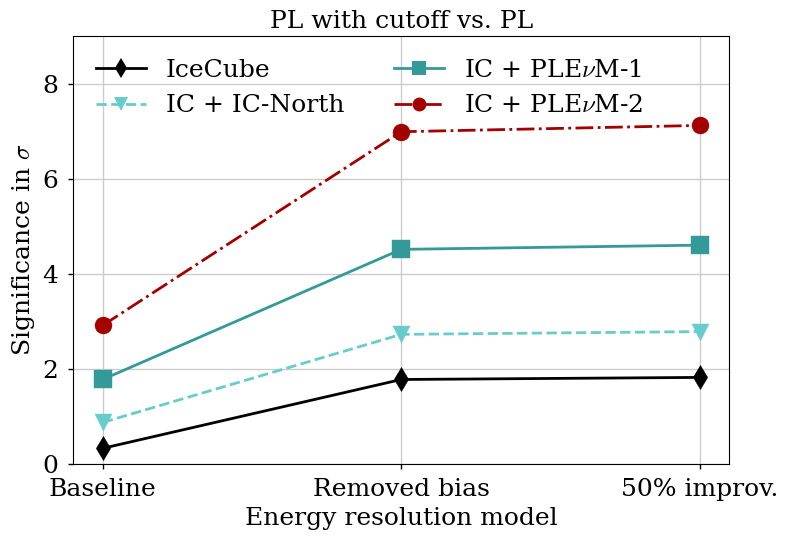

In [45]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby("key"):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 9)
ax.legend(loc=2, ncol=2, frameon=False)  # , fontsize="large")
ax.set_title("PL with cutoff vs. PL")  # , fontsize=18)
ax.set_xlabel("Energy resolution model")  # , fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$")  # , fontsize=18)
f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/cutoff_sigma_vs_eres_ngc.pdf"))

In [46]:
pval_df.loc[pval_df.e_smearing=="Baseline"]

,identifier,key,e_smearing,pval,Significance in $\sigma$
0,IceCube,IceCube,Baseline,0.371607,0.327600
3,IC + IC-North,P-ONE,Baseline,0.191332,0.872998
6,IC + PLE$\nu$M-1,Plenum-1,Baseline,0.037677,1.778308
9,IC + PLE$\nu$M-2,Plenum-2,Baseline,0.001768,2.916805


## spectral fit vs. dec

scan for right threshold

In [47]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in detector_keys:
    conf = st.detector_configurations[ident]

    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_cut_flux,
        )

        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)

        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
            )

            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(1E-4, 10), (1E-4, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_sig": np.sum(current_k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(pval),
                "pval": pval
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:32<00:00,  5.75s/it]


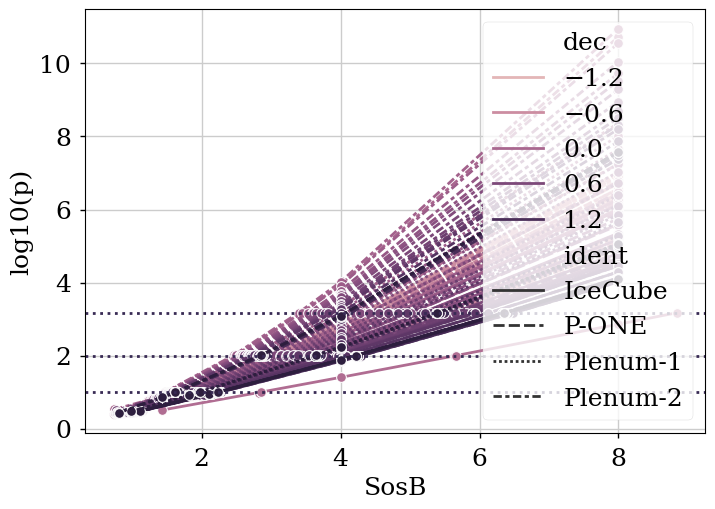

In [48]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB"  # "scaler" #
ax = sns.lineplot(data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


In [49]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()


In [50]:
flux.to_pickle(join(st.BASEPATH, "resources/flux_ngc_spectral_disc_pot.pickle"))

Text(0.5, 0.98, 'Spectral discrimination: \n PL vs. PL with cutoff')

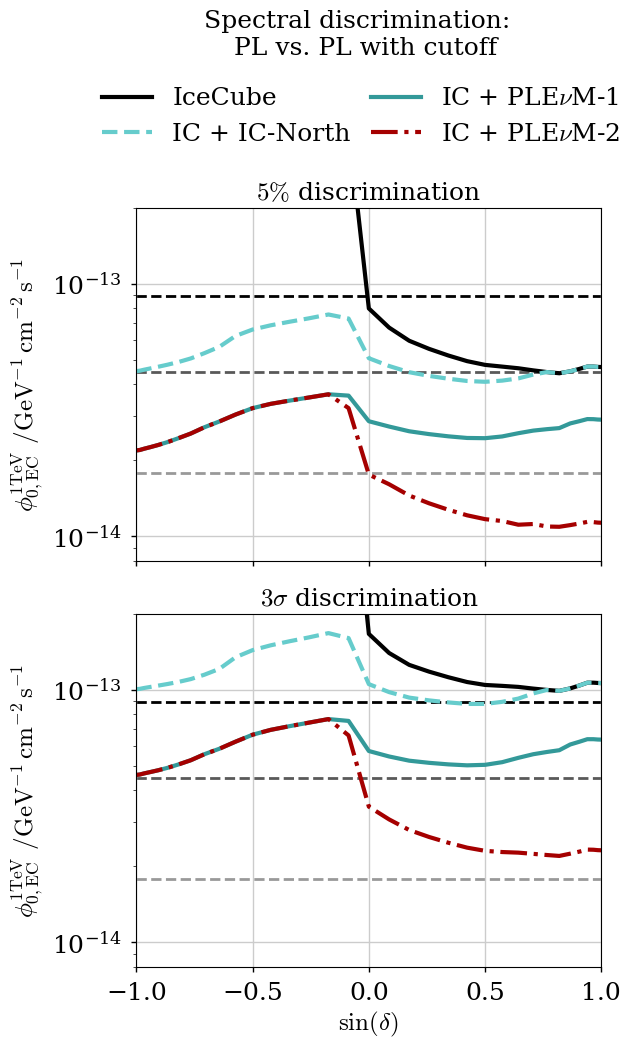

In [51]:

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
# )
# see plotting_standalone.ipynb for final version

Text(0.12, 0.98, 'Spectral discrimination: PL vs. PL with cutoff')

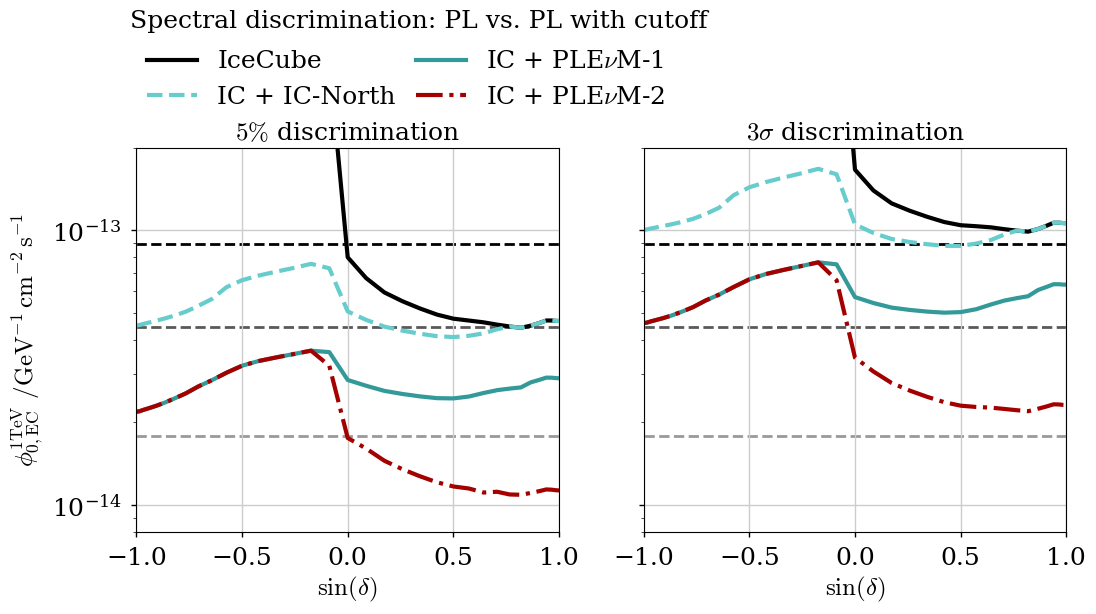

In [52]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r"$\sin(\delta)$", fontsize=18)
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.35, 0.95),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[0].set_ylabel(
    r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=18,
)
f.subplots_adjust(hspace=0.15, top=0.75)
f.suptitle("Spectral discrimination: PL vs. PL with cutoff", fontsize=18, ha="left", x=0.12)
# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot_horizontal.pdf"),
#     bbox_inches="tight",
# )
# see plotting_standalone.ipynb for final version